# BDPM — Base de Données Publique des Médicaments

**What:** Official reference database for all drugs authorized in France — AMM status, compositions, prices, reimbursement rates, generic groups.

**Why it matters:** Drug reference data — decodes CIP/CIS codes from Open Medic and maps drugs to active substances, labs, and therapeutic positioning.

| Property | Value |
|----------|-------|
| Source | base-donnees-publique.medicaments.gouv.fr |
| Format | Tab-separated TXT (no headers) |
| Encoding | UTF-8 |
| Size | ~4 MB total (8 small files) |

In [1]:
import httpx
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RAW_DIR = Path("../../data/raw/bdpm")
RAW_DIR.mkdir(parents=True, exist_ok=True)

BASE_URL = "https://base-donnees-publique.medicaments.gouv.fr/download/file/"
FILES = {
    "CIS_bdpm.txt": "Drug specialties (main table)",
    "CIS_CIP_bdpm.txt": "Presentations (CIP13, prices, reimbursement)",
    "CIS_COMPO_bdpm.txt": "Compositions (active substances)",
    "CIS_GENER_bdpm.txt": "Generic groups",
    "CIS_HAS_SMR_bdpm.txt": "SMR opinions (medical benefit)",
    "CIS_HAS_ASMR_bdpm.txt": "ASMR opinions (improvement of medical benefit)",
    "CIS_CPD_bdpm.txt": "Prescribing/dispensing conditions",
    "HAS_LiensPageCT_bdpm.txt": "HAS transparency commission links",
}

for fname, desc in FILES.items():
    dest = RAW_DIR / fname
    if dest.exists():
        print(f"  [skip] {fname}")
        continue
    print(f"  Downloading {fname} ({desc})...", end=" ")
    resp = httpx.get(f"{BASE_URL}{fname}", follow_redirects=True, timeout=60)
    resp.raise_for_status()
    dest.write_bytes(resp.content)
    print(f"{len(resp.content) / 1024:.0f} KB")

print("\nAll BDPM files ready.")

  [skip] CIS_bdpm.txt
  [skip] CIS_CIP_bdpm.txt
  [skip] CIS_COMPO_bdpm.txt
  [skip] CIS_GENER_bdpm.txt
  [skip] CIS_HAS_SMR_bdpm.txt
  [skip] CIS_HAS_ASMR_bdpm.txt
  [skip] CIS_CPD_bdpm.txt
  [skip] HAS_LiensPageCT_bdpm.txt

All BDPM files ready.


## Load the 3 main tables

In [2]:
# --- CIS_bdpm: Drug specialties ---
specialites = pd.read_csv(
    RAW_DIR / "CIS_bdpm.txt", sep="\t", header=None, encoding="latin-1",
    names=["code_cis", "denomination", "forme_pharma", "voie_admin",
           "statut_amm", "type_procedure", "etat_commercialisation",
           "date_amm", "statut_bdm", "numero_autorisation_euro",
           "titulaire", "surveillance_renforcee"],
   )
print(f"Drug specialties: {len(specialites):,} rows")
specialites.head()

Drug specialties: 15,822 rows


,code_cis,denomination,forme_pharma,voie_admin,statut_amm,type_procedure,etat_commercialisation,date_amm,statut_bdm,numero_autorisation_euro,titulaire,surveillance_renforcee
0,61266250,"A 313 200 000 UI POUR CENT, pommade",pommade,cutanée,Autorisation active,Procédure nationale,Commercialisée,12/03/1998,NaN,NaN,PHARMA DEVELOPPEMENT,Non
1,62869109,"A 313 50 000 U.I., capsule molle",capsule molle,orale,Autorisation active,Procédure nationale,Commercialisée,07/07/1997,NaN,NaN,PHARMA DEVELOPPEMENT,Non
2,69103878,"A.D.N. BOIRON, degré de dilution compris entre...",comprimé et solution(s) et granules et poudre...,cutanée;orale;sublinguale,Autorisation active,Enreg homéo (Proc. Nat.),Commercialisée,14/10/2021,NaN,NaN,BOIRON,Non
3,61876780,"ABACAVIR ARROW 300 mg, comprimé pelliculé sécable",comprimé pelliculé sécable,orale,Autorisation active,Procédure décentralisée,Commercialisée,22/10/2019,NaN,NaN,ARROW GENERIQUES,Non
4,63797011,"ABACAVIR SANDOZ 300 mg, comprimé pelliculé séc...",comprimé pelliculé sécable,orale,Autorisation active,Procédure décentralisée,Commercialisée,30/12/2016,NaN,NaN,SANDOZ,Non


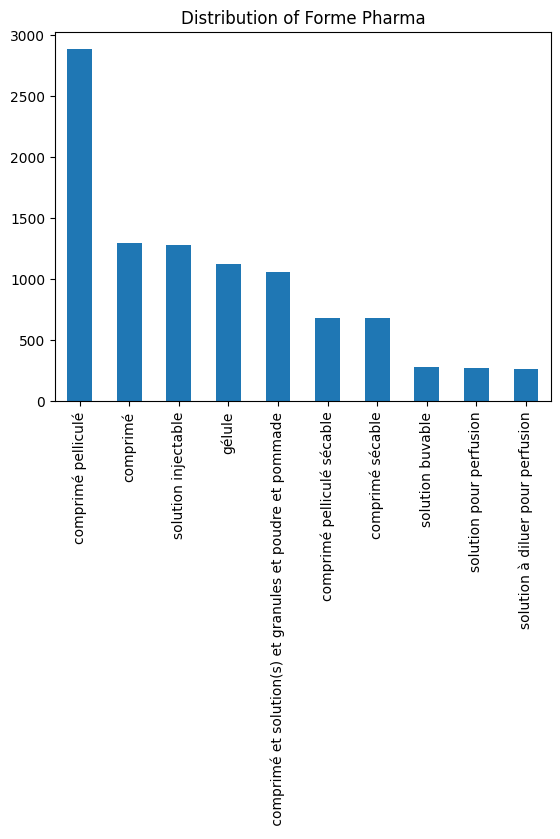

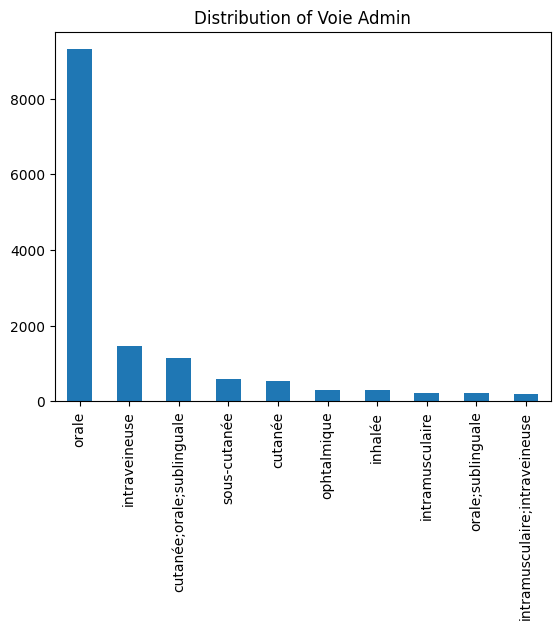

In [3]:
# plot distribution of forme pharma and voie_admin
specialites["forme_pharma"].value_counts().head(10).plot(kind="bar", title="Distribution of Forme Pharma")
plt.xticks(rotation=90)
plt.show()
specialites["voie_admin"].value_counts().head(10).plot(kind="bar", title="Distribution of Voie Admin")
plt.xticks(rotation=90)
plt.show()

In [4]:
# --- CIS_CIP_bdpm: Presentations (CIP13, prices) ---
presentations = pd.read_csv(
    RAW_DIR / "CIS_CIP_bdpm.txt", sep="\t", header=None, encoding="utf-8",
    names=["code_cis", "code_cip7", "libelle_presentation", "statut_admin",
           "etat_commercialisation", "date_declaration", "code_cip13",
           "agrement_collectivites", "taux_remboursement", "prix_sans_honoraire",
           "prix_avec_honoraire", "honoraire_dispensation", "indications_remboursement"],
)
print(f"Presentations: {len(presentations):,} rows")
presentations.head()

Presentations: 20,894 rows


,code_cis,code_cip7,libelle_presentation,statut_admin,etat_commercialisation,date_declaration,code_cip13,agrement_collectivites,taux_remboursement,prix_sans_honoraire,prix_avec_honoraire,honoraire_dispensation,indications_remboursement
0,60002283,4949729,plaquette(s) PVC PVDC aluminium de 30 comprimé(s),Présentation active,Déclaration de commercialisation,16/03/2011,3400949497294,oui,100%,"24,34","25,36","1,02",NaN
1,60002283,4949770,plaquette(s) PVC PVDC aluminium de 90 comprimé(s),Présentation active,Déclaration de commercialisation,19/09/2011,3400949497706,oui,100%,"68,68","71,44","2,76",NaN
2,60003620,3696350,20 récipient(s) unidose(s) polyéthylène de 2 m...,Présentation active,Déclaration de commercialisation,30/11/2006,3400936963504,oui,65%,"12,81","13,83","1,02",Ce médicament peut être pris en charge ou remb...
3,60004277,3614582,plaquette(s) thermoformée(s) PVC aluminium de ...,Présentation active,Déclaration de commercialisation,11/06/2003,3400936145825,oui,65%,"1,54","2,56","1,02",NaN
4,60004487,3972519,plaquette(s) opaque(s) PVC-Aluminium de 30 com...,Présentation active,Déclaration de commercialisation,12/12/2011,3400939725192,oui,65%,"8,88","9,90","1,02",NaN


In [5]:
# --- CIS_COMPO_bdpm: Compositions ---
compositions = pd.read_csv(
    RAW_DIR / "CIS_COMPO_bdpm.txt", sep="\t", header=None, encoding="latin-1",
    names=["code_cis", "designation_element", "code_substance",
           "denomination_substance", "dosage", "ref_dosage",
           "nature_composant", "numero_liaison_sa_ft"],
)
print(f"Compositions: {len(compositions):,} rows")
compositions.head()

Compositions: 32,466 rows


,code_cis,designation_element,code_substance,denomination_substance,dosage,ref_dosage,nature_composant,numero_liaison_sa_ft
0,60002283,comprimé,42215,ANASTROZOLE,"1,00 mg",un comprimé,SA,1
1,60002746,granules,5319,ACTAEA RACEMOSA POUR PRÉPARATIONS HOMÉOPATHIQUES,2CH à 30CH et 4DH à 60DH,un comprimé,SA,7
2,60002746,solution buvable en gouttes,5319,ACTAEA RACEMOSA POUR PRÉPARATIONS HOMÉOPATHIQUES,2CH à 30CH et 4DH à 60DH,un comprimé,SA,8
3,60003620,suspension,4179,DIPROPIONATE DE BÉCLOMÉTASONE,800 microgrammes,2 ml de suspension,SA,1
4,60004277,gélule,3902,FÉNOFIBRATE,"100,00 mg",une gélule,SA,1


## Explore: Top labs, substances, forms

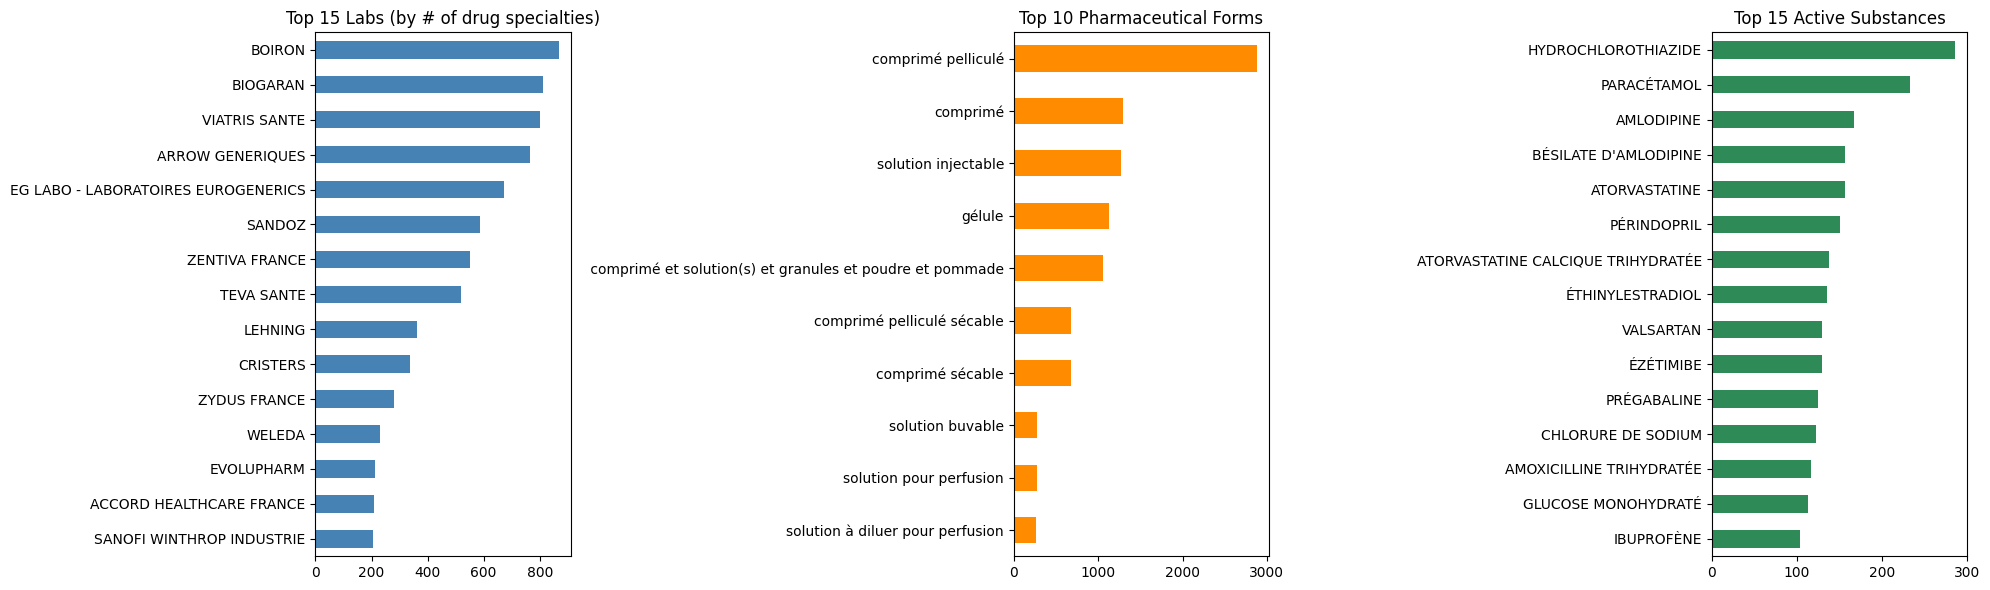

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Top 15 labs
specialites["titulaire"].str.strip().value_counts().head(15).sort_values().plot.barh(
    ax=axes[0], color="steelblue")
axes[0].set_title("Top 15 Labs (by # of drug specialties)")

# Top 10 pharma forms
specialites["forme_pharma"].value_counts().head(10).sort_values().plot.barh(
    ax=axes[1], color="darkorange")
axes[1].set_title("Top 10 Pharmaceutical Forms")

# Top 15 active substances
compositions["denomination_substance"].str.strip().value_counts().head(15).sort_values().plot.barh(
    ax=axes[2], color="seagreen")
axes[2].set_title("Top 15 Active Substances")

plt.tight_layout()
plt.show()

In [7]:
# Reimbursement rate distribution
print("Reimbursement rates:\n")
print(presentations["taux_remboursement"].value_counts(dropna=False).to_string())

Reimbursement rates:

65%      8509
NaN      7707
65 %     2049
30%       805
100%      701
100 %     463
30 %      307
15%       251
15 %       94
35%         8


In [8]:
# AMM status breakdown
print("AMM statuses:\n")
print(specialites["statut_amm"].value_counts().to_string())

AMM statuses:

Autorisation active       14817
Autorisation abrogée        794
Autorisation archivée       195
Autorisation retirée         10
Autorisation suspendue        6


In [9]:
# Generics
generiques = pd.read_csv(
    RAW_DIR / "CIS_GENER_bdpm.txt", sep="\t", header=None, encoding="latin-1",
    names=["id_groupe", "libelle_groupe", "code_cis", "type_generique",
           "numero_tri", "col6"],
)
print(f"Generic groups: {generiques['id_groupe'].nunique():,} groups")
print(f"Drugs in generic groups: {generiques['code_cis'].nunique():,}")
print(f"\nType distribution:")
print(generiques["type_generique"].value_counts().to_string())

Generic groups: 1,645 groups
Drugs in generic groups: 10,535

Type distribution:
1    8747
0    1767
4      61
2      36


## Quick DuckDB query demo

In [10]:
!pip install duckdb

In [11]:
import duckdb

con = duckdb.connect(":memory:")
con.register("specialites", specialites)
con.register("compositions", compositions)
con.register("presentations", presentations)

con.sql("""
    SELECT
        TRIM(s.titulaire) AS lab,
        COUNT(DISTINCT s.code_cis) AS nb_drugs,
        COUNT(DISTINCT c.denomination_substance) AS nb_unique_substances
    FROM specialites s
    JOIN compositions c ON s.code_cis = c.code_cis
    GROUP BY TRIM(s.titulaire)
    ORDER BY nb_drugs DESC
    LIMIT 10
""").show()

┌─────────────────────────────────────┬──────────┬──────────────────────┐
│                 lab                 │ nb_drugs │ nb_unique_substances │
│               varchar               │  int64   │        int64         │
├─────────────────────────────────────┼──────────┼──────────────────────┤
│ BOIRON                              │      868 │                  810 │
│ BIOGARAN                            │      813 │                  475 │
│ VIATRIS SANTE                       │      800 │                  519 │
│ ARROW GENERIQUES                    │      766 │                  425 │
│ EG LABO - LABORATOIRES EUROGENERICS │      673 │                  429 │
│ SANDOZ                              │      587 │                  384 │
│ ZENTIVA FRANCE                      │      551 │                  371 │
│ TEVA SANTE                          │      519 │                  327 │
│ LEHNING                             │      363 │                  381 │
│ CRISTERS                            

---

## Analyse : quatre questions clés sur la BDPM

Les données BDPM permettent de répondre à quatre questions structurantes sur le marché pharmaceutique français.

| # | Question | Fichiers utilisés |
|---|---------|-------------------|
| Q1 | Quand les médicaments ont-ils obtenu leur AMM ? | `CIS_bdpm` → `date_amm` |
| Q2 | Comment se distribuent les prix et le remboursement ? | `CIS_CIP_bdpm` → `taux_remboursement`, `prix_avec_honoraire` |
| Q3 | Quelle valeur clinique la HAS reconnaît-elle ? | `CIS_HAS_SMR_bdpm`, `CIS_HAS_ASMR_bdpm` |
| Q4 | Où la concurrence générique est-elle la plus intense ? | `CIS_GENER_bdpm` |

### Q1 — Évolution temporelle : quand les médicaments ont-ils obtenu leur AMM ?

Le parc de médicaments autorisés en France s'est constitué sur plusieurs décennies. La date d'AMM révèle les grandes vagues d'enregistrement : montée en puissance dans les années 1990-2000 avec l'harmonisation européenne, puis plateau récent avec l'essor des thérapies ciblées et des biosimilaires. Le code couleur distingue les médicaments encore actifs (vert) de ceux dont l'autorisation a été abrogée, archivée ou retirée (gris/rouge).

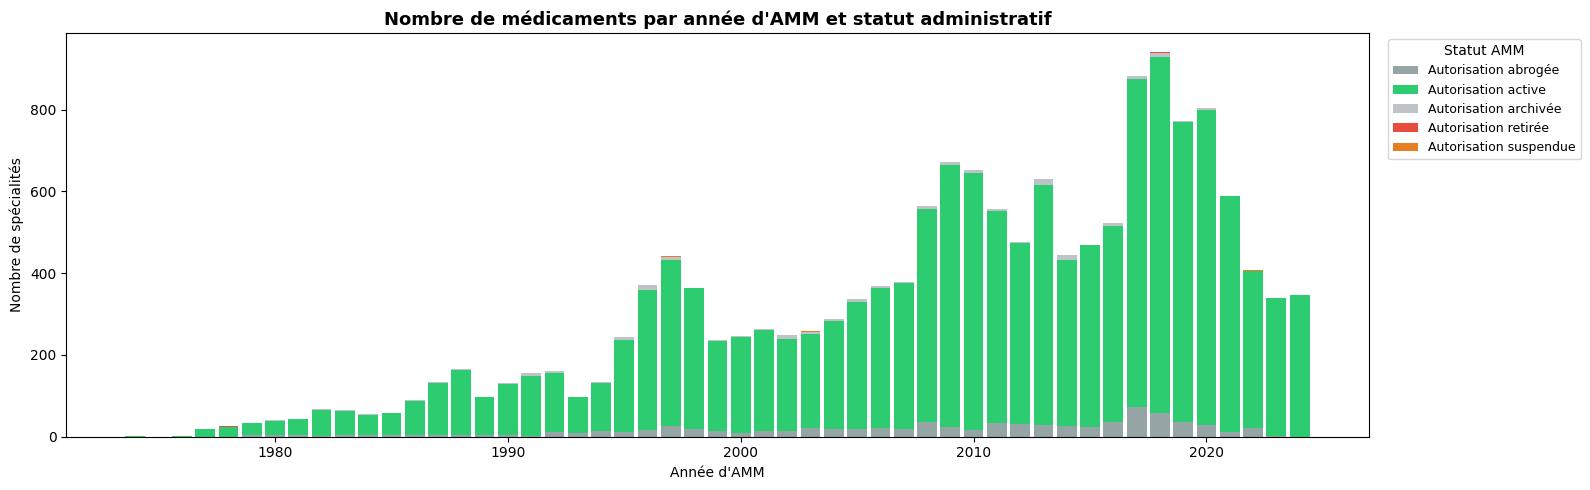

Âge médian du parc (depuis l'AMM)  : 13 ans
Médicaments avec AMM avant 1990    : 899
Médicaments avec AMM depuis 2015   : 6,200


In [12]:
specialites["date_amm_dt"] = pd.to_datetime(
    specialites["date_amm"], format="%d/%m/%Y", errors="coerce"
)
specialites["annee_amm"] = specialites["date_amm_dt"].dt.year

by_year = (
    specialites[specialites["annee_amm"].between(1950, 2024)]
    .groupby(["annee_amm", "statut_amm"])
    .size()
    .reset_index(name="n")
)
pivot = by_year.pivot(index="annee_amm", columns="statut_amm", values="n").fillna(0)

color_map = {
    "Autorisation active":    "#2ecc71",
    "Autorisation abrogée":   "#95a5a6",
    "Autorisation archivée":  "#bdc3c7",
    "Autorisation retirée":   "#e74c3c",
    "Autorisation suspendue": "#e67e22",
}

fig, ax = plt.subplots(figsize=(16, 5))
bottom = None
for col in pivot.columns:
    color = color_map.get(col, "#999999")
    vals  = pivot[col].values
    if bottom is None:
        ax.bar(pivot.index, vals, label=col, color=color, width=0.85)
        bottom = vals.copy()
    else:
        ax.bar(pivot.index, vals, bottom=bottom, label=col, color=color, width=0.85)
        bottom = bottom + vals

ax.set_title(
    "Nombre de médicaments par année d'AMM et statut administratif",
    fontsize=13, fontweight="bold"
)
ax.set_xlabel("Année d'AMM")
ax.set_ylabel("Nombre de spécialités")
ax.legend(title="Statut AMM", bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

age_median = 2024 - specialites["annee_amm"].median()
print(f"Âge médian du parc (depuis l'AMM)  : {age_median:.0f} ans")
print(f"Médicaments avec AMM avant 1990    : {(specialites['annee_amm'] < 1990).sum():,}")
print(f"Médicaments avec AMM depuis 2015   : {(specialites['annee_amm'] >= 2015).sum():,}")

### Q2 — Structure économique : comment se distribuent les prix et le remboursement ?

Le taux de remboursement est la variable économique centrale du marché officinal. En France, il est déterminé par le SMR attribué par la HAS. Les médicaments à **65%** constituent la grande masse du marché remboursé. Les **100%** concernent principalement les ALD (affections de longue durée).


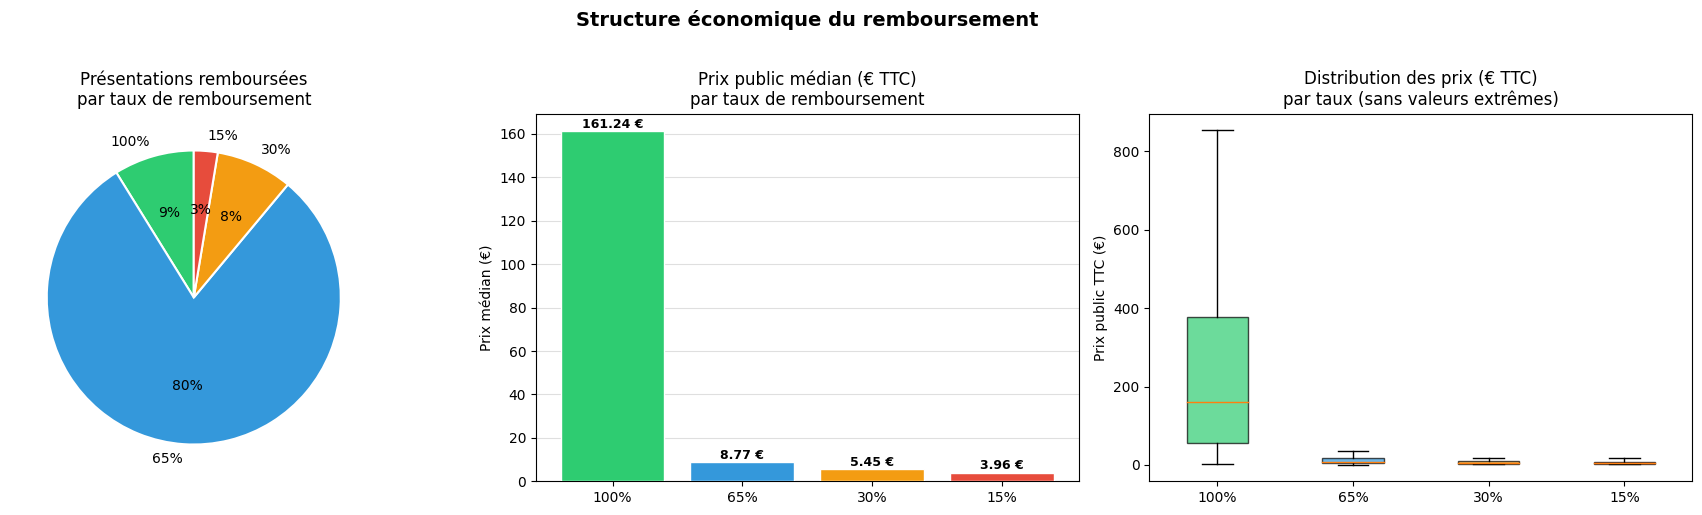

Résumé des prix par taux de remboursement :
  100%: n=1,164  médiane=161.24€  p90=695.72€  max=993.51€
  65%: n=10,558  médiane=8.77€  p90=46.39€  max=949.25€
  30%: n=1,112  médiane=5.45€  p90=18.62€  max=972.76€
  15%: n=345  médiane=3.96€  p90=17.91€  max=516.46€


In [22]:
pres = presentations.copy()
pres["taux_clean"] = (
    pres["taux_remboursement"].astype(str).str.strip().str.replace(" ", "")
)
pres["taux_clean"] = pres["taux_clean"].where(
    pres["taux_clean"].isin(["100%", "65%", "30%", "15%"])
)
pres["prix_num"] = pd.to_numeric(
    pres["prix_avec_honoraire"].astype(str).str.replace(",", "."), errors="coerce"
)

taux_order  = ["100%", "65%", "30%", "15%"]
colors_taux = ["#2ecc71", "#3498db", "#f39c12", "#e74c3c"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Répartition des présentations remboursées
taux_counts = pres["taux_clean"].value_counts(dropna=True)
vals = [taux_counts.get(t, 0) for t in taux_order]
axes[0].pie(
    vals, labels=taux_order, autopct="%1.0f%%", colors=colors_taux,
    startangle=90, wedgeprops={"edgecolor": "white", "linewidth": 1.5},
)
axes[0].set_title("Présentations remboursées\npar taux de remboursement")

# 2. Prix médian par taux
medians = [pres[pres["taux_clean"] == t]["prix_num"].median() for t in taux_order]
bars = axes[1].bar(taux_order, medians, color=colors_taux, edgecolor="white", zorder=3)
axes[1].set_title("Prix public médian (€ TTC)\npar taux de remboursement")
axes[1].set_ylabel("Prix médian (€)")
axes[1].grid(axis="y", alpha=0.4, zorder=0)
for bar, v in zip(bars, medians):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2, v + 0.3,
        f"{v:.2f} €", ha="center", va="bottom", fontsize=9, fontweight="bold"
    )

# 3. Boxplot des prix par taux
data_by_taux = [pres[pres["taux_clean"] == t]["prix_num"].dropna() for t in taux_order]
bp = axes[2].boxplot(data_by_taux, labels=taux_order, showfliers=False, patch_artist=True)
for patch, color in zip(bp["boxes"], colors_taux):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[2].set_title("Distribution des prix (€ TTC)\npar taux (sans valeurs extrêmes)")
axes[2].set_ylabel("Prix public TTC (€)")

plt.suptitle("Structure économique du remboursement", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print("Résumé des prix par taux de remboursement :")
for t in taux_order:
    s = pres[pres["taux_clean"] == t]["prix_num"]
    print(f"  {t}: n={len(s):,}  médiane={s.median():.2f}€  p90={s.quantile(0.9):.2f}€  max={s.max():.2f}€")

### Q3 — Évaluation clinique HAS : quelle valeur thérapeutique reconnaît-on aux médicaments ?

La Commission de la Transparence de la HAS attribue deux évaluations clés :
- **SMR** (Service Médical Rendu) → détermine le taux de remboursement
- **ASMR** (Amélioration du SMR) → détermine la marge de prix lors de la négociation avec le CEPS

L'ASMR V («&nbsp;pas d'amélioration&nbsp;») concerne la grande majorité des médicaments mis sur le marché. La heatmap ci-dessous vérifie la cohérence entre le SMR attribué et le taux de remboursement effectif : un SMR Important devrait quasi-systématiquement aboutir à un taux de 65% ou 100%.

SMR  : 8,954 spécialités évaluées
ASMR : 6,108 spécialités évaluées


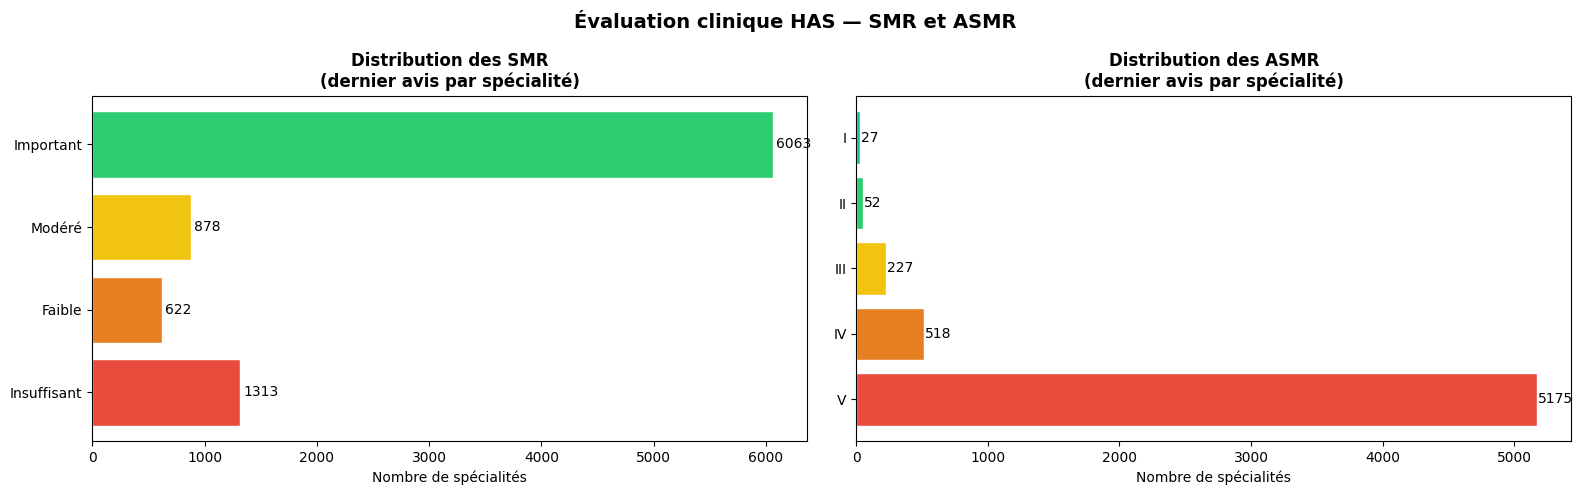

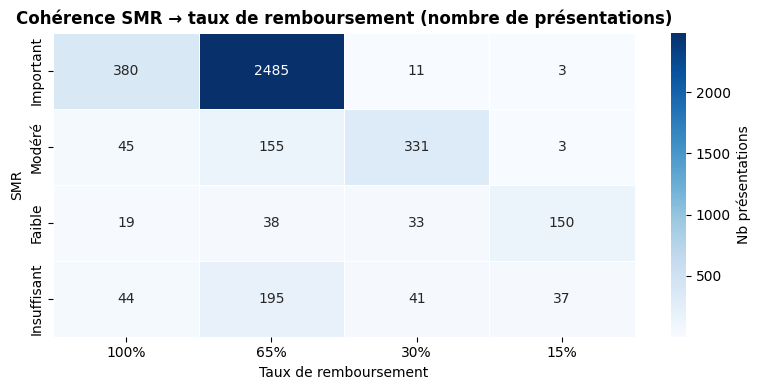

In [14]:
import seaborn as sns

smr = pd.read_csv(
    RAW_DIR / "CIS_HAS_SMR_bdpm.txt", sep="\t", header=None, encoding="latin-1",
    names=["code_cis", "code_dossier", "motif", "date_avis", "valeur_smr", "libelle_smr"],
)
asmr = pd.read_csv(
    RAW_DIR / "CIS_HAS_ASMR_bdpm.txt", sep="\t", header=None, encoding="latin-1",
    names=["code_cis", "code_dossier", "motif", "date_avis", "valeur_asmr", "libelle_asmr"],
)

# Keep only latest opinion per drug
smr_latest = smr.sort_values("date_avis").groupby("code_cis").last().reset_index()
asmr_latest = asmr.sort_values("date_avis").groupby("code_cis").last().reset_index()
smr_latest["valeur_smr"] = smr_latest["valeur_smr"].str.strip()
asmr_latest["valeur_asmr"] = asmr_latest["valeur_asmr"].str.strip()

print(f"SMR  : {len(smr_latest):,} spécialités évaluées")
print(f"ASMR : {len(asmr_latest):,} spécialités évaluées")

smr_order   = ["Important", "Modéré", "Faible", "Insuffisant"]
smr_colors  = ["#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]
asmr_order  = ["I", "II", "III", "IV", "V"]
asmr_colors = ["#1abc9c", "#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- SMR distribution ---
smr_counts = smr_latest["valeur_smr"].value_counts()
vals_smr = [smr_counts.get(s, 0) for s in smr_order]
bars_smr = axes[0].barh(smr_order, vals_smr, color=smr_colors, edgecolor="white")
axes[0].set_title("Distribution des SMR\n(dernier avis par spécialité)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Nombre de spécialités")
for bar, v in zip(bars_smr, vals_smr):
    axes[0].text(v + 30, bar.get_y() + bar.get_height() / 2, str(v), va="center", fontsize=10)
axes[0].invert_yaxis()

# --- ASMR distribution ---
asmr_counts = asmr_latest["valeur_asmr"].value_counts()
vals_asmr = [asmr_counts.get(a, 0) for a in asmr_order]
bars_asmr = axes[1].barh(asmr_order, vals_asmr, color=asmr_colors, edgecolor="white")
axes[1].set_title("Distribution des ASMR\n(dernier avis par spécialité)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Nombre de spécialités")
for bar, v in zip(bars_asmr, vals_asmr):
    axes[1].text(v + 5, bar.get_y() + bar.get_height() / 2, str(v), va="center", fontsize=10)
axes[1].invert_yaxis()

plt.suptitle("Évaluation clinique HAS — SMR et ASMR", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# --- Heatmap: SMR → taux de remboursement ---
pres_clean = presentations.copy()
pres_clean["taux_clean"] = (
    pres_clean["taux_remboursement"].astype(str).str.strip().str.replace(" ", "")
)
pres_clean["taux_clean"] = pres_clean["taux_clean"].where(
    pres_clean["taux_clean"].isin(["100%", "65%", "30%", "15%"])
)
smr_pres = smr_latest.merge(
    pres_clean[["code_cis", "taux_clean"]].dropna().drop_duplicates(),
    on="code_cis", how="inner"
)
cross = pd.crosstab(smr_pres["valeur_smr"], smr_pres["taux_clean"])
cross = cross.reindex(index=smr_order, columns=["100%", "65%", "30%", "15%"], fill_value=0)

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(cross, annot=True, fmt="d", cmap="Blues", ax=ax,
            linewidths=0.5, cbar_kws={"label": "Nb présentations"})
ax.set_title("Cohérence SMR → taux de remboursement (nombre de présentations)",
             fontsize=12, fontweight="bold")
ax.set_xlabel("Taux de remboursement")
ax.set_ylabel("SMR")
plt.tight_layout()
plt.show()

### Q4 — Génériques : où la concurrence est-elle la plus intense ?

Le répertoire des génériques classe chaque groupe par type : **0** (princeps), **1** (générique standard), **4** (générique substituable). Plus un groupe est peuplé, plus la pression concurrentielle sur les prix est forte. Cette fragmentation est la conséquence directe de l'expiration des brevets et de la politique de l'Assurance Maladie en faveur des génériques.

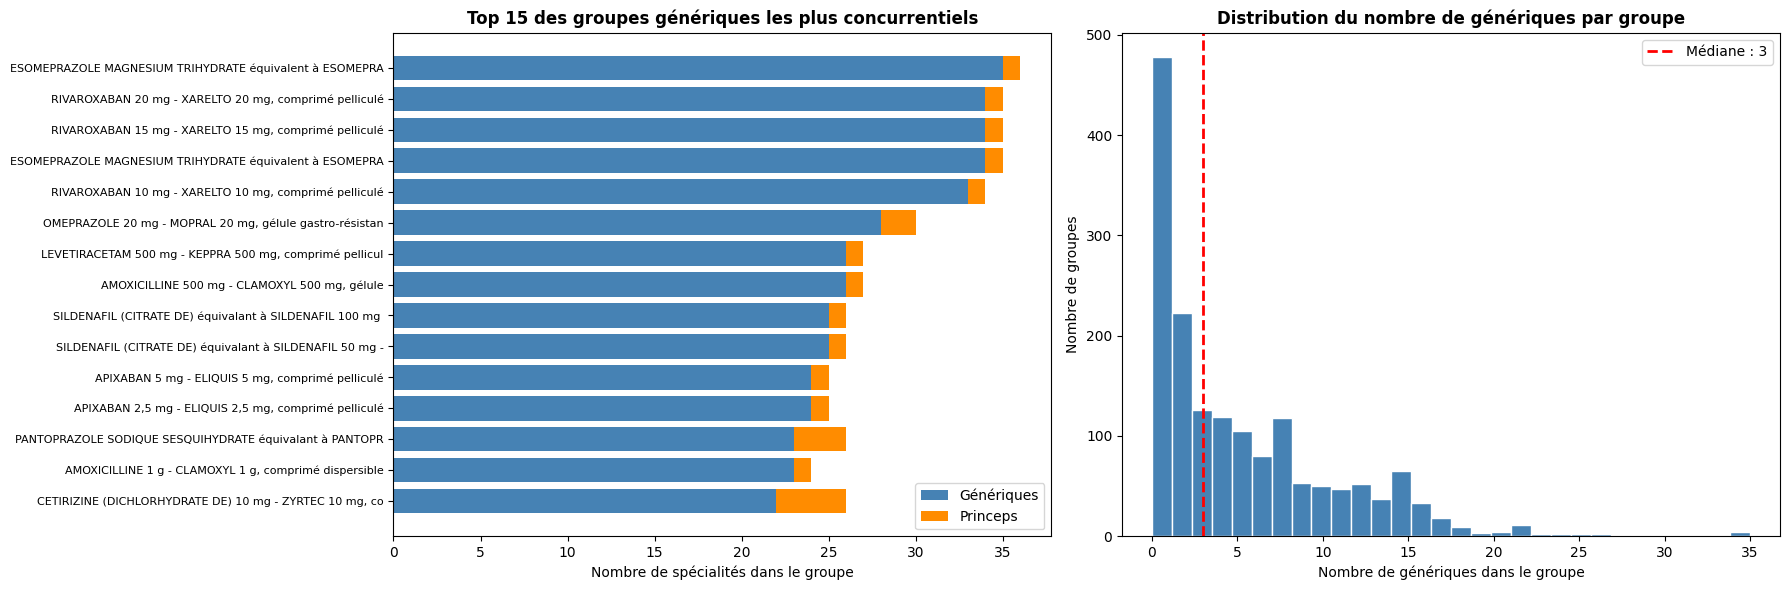

Médicaments dans un groupe générique : 10,535 / 15,822 (66.6%)

Distribution de la taille des groupes :
  1 générique        : 362 groupes
  2 à 5 génériques   : 573 groupes
  6 à 10 génériques  : 301 groupes
  Plus de 10         : 293 groupes


In [15]:
gen_stats = generiques.groupby("id_groupe").agg(
    libelle=("libelle_groupe", "first"),
    n_princeps=("type_generique", lambda x: (x == 0).sum()),
    n_generiques=("type_generique", lambda x: x.isin([1, 2, 4]).sum()),
    n_total=("code_cis", "count"),
).reset_index()

top15 = gen_stats.nlargest(15, "n_generiques").sort_values("n_generiques")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Stacked bar: top 15 most competitive groups
axes[0].barh(range(len(top15)), top15["n_generiques"], color="steelblue", label="Génériques")
axes[0].barh(
    range(len(top15)), top15["n_princeps"],
    left=top15["n_generiques"], color="darkorange", label="Princeps"
)
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels([l[:55] for l in top15["libelle"]], fontsize=8)
axes[0].set_xlabel("Nombre de spécialités dans le groupe")
axes[0].set_title("Top 15 des groupes génériques les plus concurrentiels", fontsize=12, fontweight="bold")
axes[0].legend()

# Distribution of group sizes
axes[1].hist(gen_stats["n_generiques"], bins=30, color="steelblue", edgecolor="white")
axes[1].set_title("Distribution du nombre de génériques par groupe", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Nombre de génériques dans le groupe")
axes[1].set_ylabel("Nombre de groupes")
med = gen_stats["n_generiques"].median()
axes[1].axvline(med, color="red", linestyle="--", linewidth=2, label=f"Médiane : {med:.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()

in_group = generiques["code_cis"].nunique()
total = specialites["code_cis"].nunique()
print(f"Médicaments dans un groupe générique : {in_group:,} / {total:,} ({in_group/total*100:.1f}%)")
print(f"\nDistribution de la taille des groupes :")
print(f"  1 générique        : {(gen_stats['n_generiques'] == 1).sum()} groupes")
print(f"  2 à 5 génériques   : {gen_stats['n_generiques'].between(2, 5).sum()} groupes")
print(f"  6 à 10 génériques  : {gen_stats['n_generiques'].between(6, 10).sum()} groupes")
print(f"  Plus de 10         : {(gen_stats['n_generiques'] > 10).sum()} groupes")

---

## Questions supplémentaires

| # | Question | Angle analytique |
|---|---------|-----------------|
| Q5 | Ville vs hôpital — comment se répartissent les médicaments ? | Circuit commercial via la voie d'administration |
| Q6 | Innovateurs vs génériqueurs — qui est qui parmi les grands labos ? | Classification des portefeuilles dans le répertoire des génériques |
| Q7 | Associations fixes — combien combinent plusieurs substances actives ? | Complexité moléculaire via `CIS_COMPO_bdpm` |
| Q8 | Concentration du marché — combien de labos contrôlent le parc ? | Courbe de Lorenz + analyse Pareto |

### Q5 — Circuit ville vs hôpital : comment se répartissent les médicaments ?

La voie d'administration est un **proxy fiable** du circuit de distribution. Une injection intraveineuse ou intramusculaire implique quasi-systématiquement l'environnement hospitalier (infrastructure, personnel qualifié). Un comprimé oral ou un patch cutané se dispense en officine de ville. Cette classification conditionne les stratégies commerciales : cibles de la force de vente, mécanismes de prix, interlocuteurs acheteurs (pharmacien hospitalier vs pharmacien d'officine).

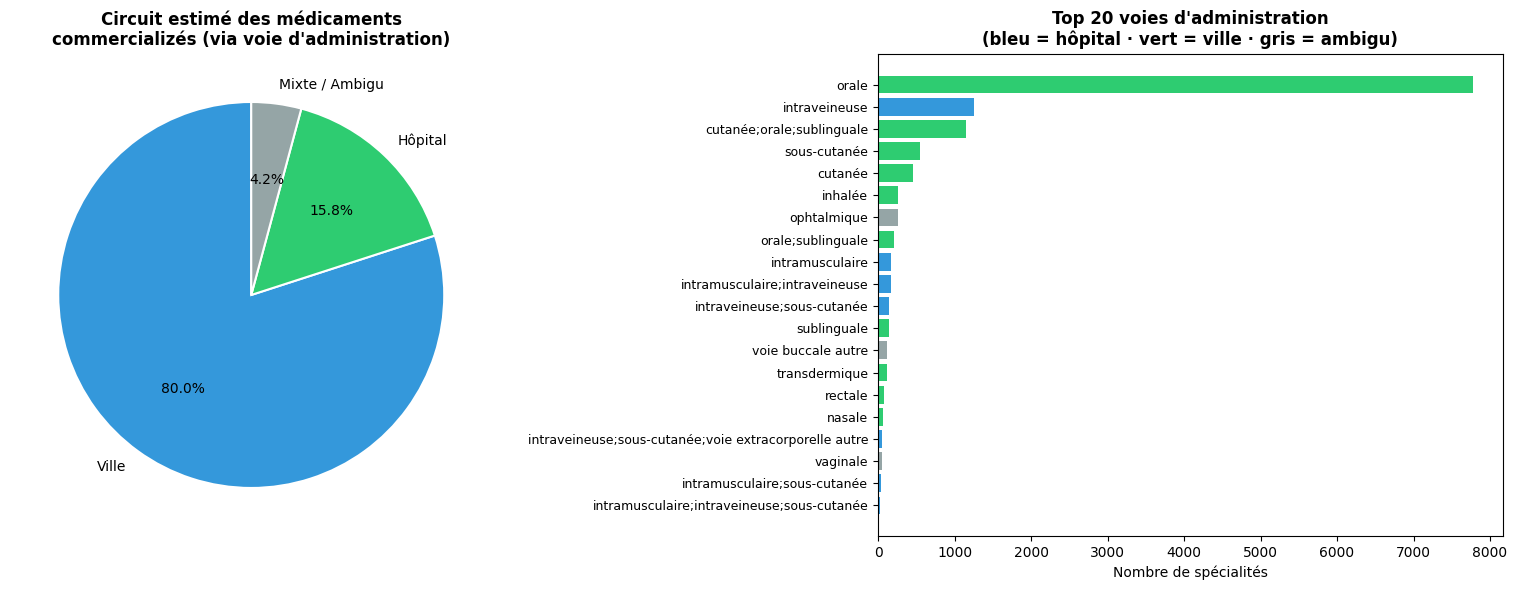

  Ville                : 10,852 spécialités (80.0%)
  Hôpital              : 2,149 spécialités (15.8%)
  Mixte / Ambigu       : 567 spécialités (4.2%)


In [16]:
HOSPITAL_ROUTES = [
    "intraveineuse", "intramusculaire", "intra-articulaire",
    "intraarticulaire", "intrathécale", "péridurale",
    "intravitréenne", "intracardiaque", "intraosseux",
    "intrapéritonéale", "intraartérielle",
]

def classify_circuit(voie):
    if pd.isna(voie):
        return "Inconnu"
    voie_lower = voie.lower()
    if any(kw in voie_lower for kw in HOSPITAL_ROUTES):
        return "Hôpital"
    if any(kw in voie_lower for kw in ["orale", "sublinguale", "rectale", "cutanée", "transdermique", "nasale", "inhalée"]):
        return "Ville"
    return "Mixte / Ambigu"

comm = specialites[specialites["etat_commercialisation"] == "Commercialisée"].copy()
comm["circuit"] = comm["voie_admin"].apply(classify_circuit)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Pie by circuit
circuit_counts = comm["circuit"].value_counts()
axes[0].pie(
    circuit_counts.values,
    labels=circuit_counts.index,
    autopct="%1.1f%%",
    colors=["#3498db", "#2ecc71", "#95a5a6"],
    startangle=90,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5},
)
axes[0].set_title("Circuit estimé des médicaments\ncommercializés (via voie d'administration)",
                  fontsize=12, fontweight="bold")

# 2. Top 20 voies, color-coded by circuit
top_voies = comm["voie_admin"].value_counts().head(20)
circuit_of_voie = [classify_circuit(v) for v in top_voies.index]
color_map_circuit = {"Hôpital": "#3498db", "Ville": "#2ecc71", "Mixte / Ambigu": "#95a5a6", "Inconnu": "#ecf0f1"}
bar_colors = [color_map_circuit[c] for c in circuit_of_voie]

axes[1].barh(range(len(top_voies)), top_voies.values, color=bar_colors)
axes[1].set_yticks(range(len(top_voies)))
axes[1].set_yticklabels(top_voies.index, fontsize=9)
axes[1].set_xlabel("Nombre de spécialités")
axes[1].set_title("Top 20 voies d'administration\n(bleu = hôpital · vert = ville · gris = ambigu)",
                  fontsize=12, fontweight="bold")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

for circuit, n in circuit_counts.items():
    pct = n / len(comm) * 100
    print(f"  {circuit:<20} : {n:,} spécialités ({pct:.1f}%)")

### Q6 — Portrait des laboratoires : innovateurs ou génériqueurs ?

Les grands laboratoires ne jouent pas tous le même rôle sur le marché. Certains sont des **innovateurs** (princeps uniquement : Sanofi, Pfizer, Servier) ; d'autres sont des **génériqueurs purs** (Biogaran, Arrow, EG Labo) dont le modèle économique repose entièrement sur la copie de molécules tombées dans le domaine public. La classification dans le répertoire des génériques (`CIS_GENER_bdpm`) permet de caractériser chaque portefeuille.

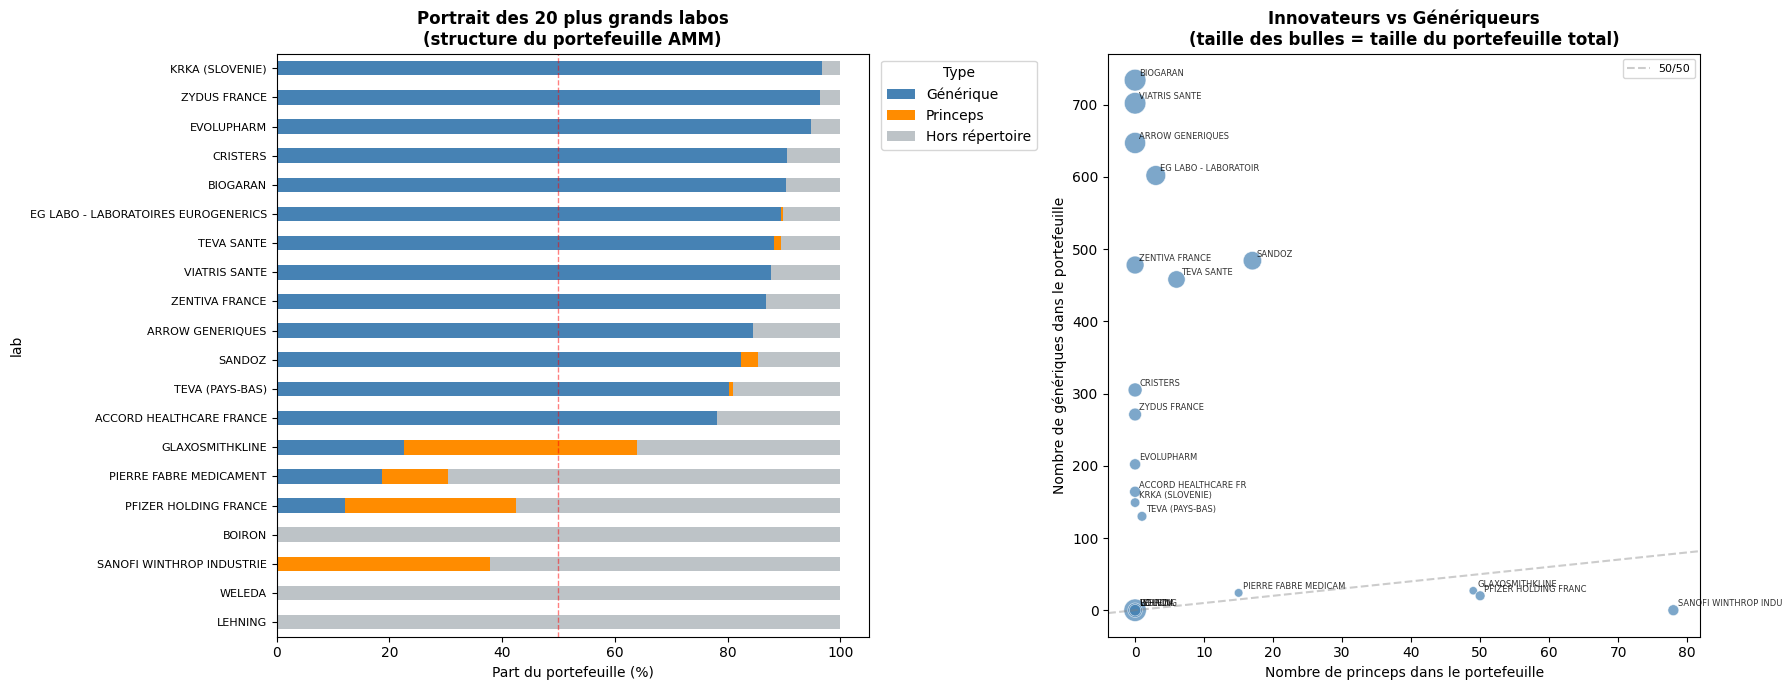

In [17]:
princeps_cis  = set(generiques[generiques["type_generique"] == 0]["code_cis"])
generique_cis = set(generiques[generiques["type_generique"].isin([1, 2, 4])]["code_cis"])

def classify_drug(cis):
    if cis in generique_cis:
        return "Générique"
    elif cis in princeps_cis:
        return "Princeps"
    return "Hors répertoire"

specialites["type_marche"] = specialites["code_cis"].apply(classify_drug)

# Profile per lab: top 20 by portfolio size
top20_labs = specialites["titulaire"].str.strip().value_counts().head(20).index
lab_profile = (
    specialites[specialites["titulaire"].str.strip().isin(top20_labs)]
    .assign(lab=lambda df: df["titulaire"].str.strip())
    .groupby(["lab", "type_marche"])
    .size()
    .unstack(fill_value=0)
)
# Ensure all columns exist
for col in ["Générique", "Princeps", "Hors répertoire"]:
    if col not in lab_profile.columns:
        lab_profile[col] = 0

lab_profile["total"] = lab_profile.sum(axis=1)
lab_pct = lab_profile[["Générique", "Princeps", "Hors répertoire"]].div(
    lab_profile["total"], axis=0
) * 100
lab_pct = lab_pct.sort_values("Générique", ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Stacked % bar
lab_pct.plot(
    kind="barh", stacked=True, ax=axes[0],
    color=["steelblue", "darkorange", "#bdc3c7"]
)
axes[0].set_xlabel("Part du portefeuille (%)")
axes[0].set_title(
    "Portrait des 20 plus grands labos\n(structure du portefeuille AMM)",
    fontsize=12, fontweight="bold"
)
axes[0].set_yticklabels([l[:35] for l in lab_pct.index], fontsize=8)
axes[0].legend(title="Type", bbox_to_anchor=(1.01, 1), loc="upper left")
axes[0].axvline(50, color="red", linestyle="--", linewidth=1, alpha=0.5)

# Absolute counts: generiques vs princeps scatter
gen_counts = lab_profile["Générique"]
pri_counts = lab_profile["Princeps"]
axes[1].scatter(pri_counts, gen_counts, s=lab_profile["total"] * 0.3,
                color="steelblue", alpha=0.7, edgecolors="white", linewidth=0.5)
for lab in lab_profile.index:
    axes[1].annotate(
        lab[:20],
        (pri_counts[lab], gen_counts[lab]),
        fontsize=6, alpha=0.8,
        xytext=(3, 3), textcoords="offset points"
    )
axes[1].set_xlabel("Nombre de princeps dans le portefeuille")
axes[1].set_ylabel("Nombre de génériques dans le portefeuille")
axes[1].set_title("Innovateurs vs Génériqueurs\n(taille des bulles = taille du portefeuille total)",
                  fontsize=12, fontweight="bold")
axes[1].axline((0, 0), slope=1, color="gray", linestyle="--", alpha=0.4, label="50/50")
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

### Q7 — Associations fixes : combien de médicaments combinent plusieurs substances actives ?

La composition d'un médicament peut contenir une ou plusieurs substances actives (SA). Les **associations fixes** combinent plusieurs molécules en un seul comprimé ou une seule injection — pratique pour améliorer l'observance (moins de comprimés à avaler) ou exploiter des synergies thérapeutiques. Le fichier `CIS_COMPO_bdpm` permet d'analyser la complexité moléculaire de chaque spécialité.

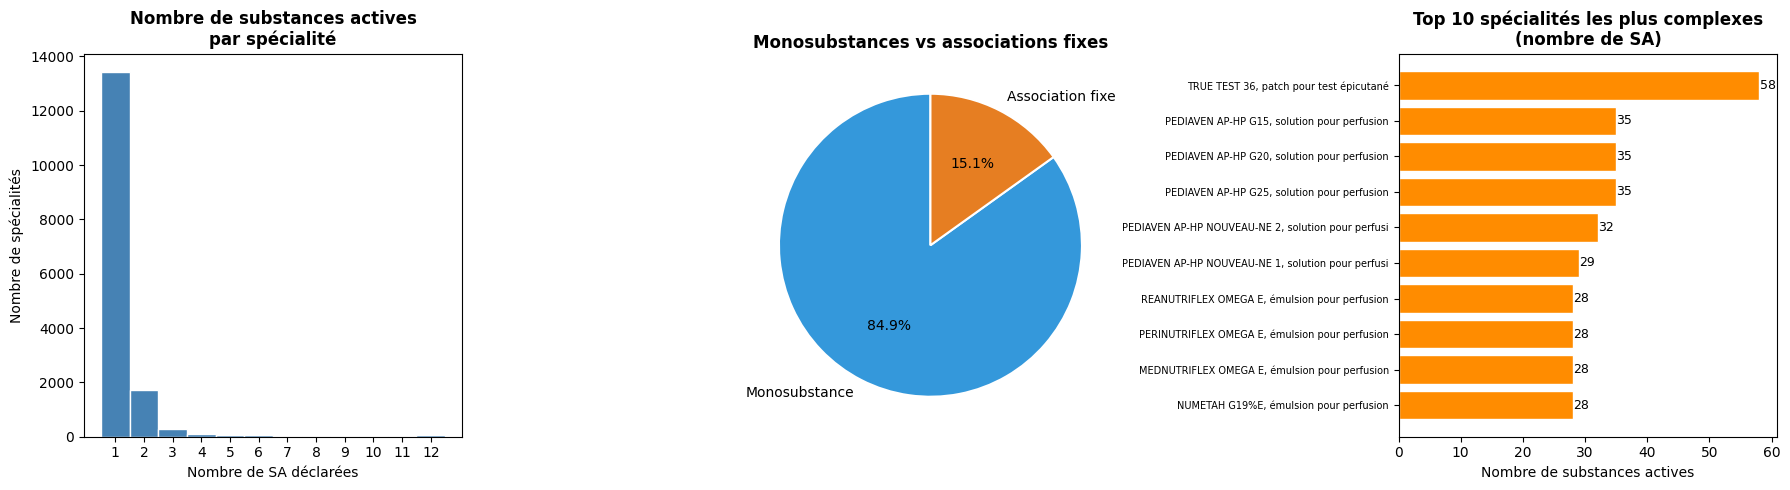

Spécialités avec 1 SA   : 13,430 (84.9%)
Associations fixes (≥2) : 2,390 (15.1%)
Associations à 3+ SA    : 662


In [18]:
# Count SA per drug (only SA nature, not ST fractions)
n_sa = (
    compositions[compositions["nature_composant"] == "SA"]
    .groupby("code_cis")["denomination_substance"]
    .nunique()
    .reset_index(name="n_substances")
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribution of substance count
max_sa = min(n_sa["n_substances"].max(), 12)
axes[0].hist(
    n_sa["n_substances"].clip(upper=max_sa),
    bins=range(1, max_sa + 2), color="steelblue", edgecolor="white", align="left"
)
axes[0].set_title("Nombre de substances actives\npar spécialité", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Nombre de SA déclarées")
axes[0].set_ylabel("Nombre de spécialités")
axes[0].set_xticks(range(1, max_sa + 1))

# 2. Mono vs association fixe pie
mono  = (n_sa["n_substances"] == 1).sum()
multi = (n_sa["n_substances"] >  1).sum()
axes[1].pie(
    [mono, multi],
    labels=["Monosubstance", "Association fixe"],
    autopct="%1.1f%%",
    colors=["#3498db", "#e67e22"],
    startangle=90,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5},
)
axes[1].set_title("Monosubstances vs associations fixes", fontsize=12, fontweight="bold")

# 3. Top 10 most complex drugs
top_complex = (
    n_sa.nlargest(10, "n_substances")
    .merge(specialites[["code_cis", "denomination"]], on="code_cis", how="left")
    .sort_values("n_substances")
)
axes[2].barh(range(len(top_complex)), top_complex["n_substances"], color="darkorange", edgecolor="white")
axes[2].set_yticks(range(len(top_complex)))
axes[2].set_yticklabels([d[:50] for d in top_complex["denomination"]], fontsize=7)
axes[2].set_xlabel("Nombre de substances actives")
axes[2].set_title("Top 10 spécialités les plus complexes\n(nombre de SA)", fontsize=12, fontweight="bold")
for i, v in enumerate(top_complex["n_substances"]):
    axes[2].text(v + 0.05, i, str(v), va="center", fontsize=9)

plt.tight_layout()
plt.show()

print(f"Spécialités avec 1 SA   : {mono:,} ({mono/len(n_sa)*100:.1f}%)")
print(f"Associations fixes (≥2) : {multi:,} ({multi/len(n_sa)*100:.1f}%)")
print(f"Associations à 3+ SA    : {(n_sa['n_substances']>=3).sum():,}")

### Q8 — Concentration du marché : combien de laboratoires contrôlent la majorité du parc ?

Le marché pharmaceutique français est-il dominé par quelques géants ou réparti entre de nombreux acteurs ? La **courbe de Lorenz** visualise cette concentration : plus la courbe s'éloigne de la diagonale d'égalité parfaite, plus le marché est concentré. Le graphe de droite révèle le poids relatif du top 20 par rapport aux centaines de petits laboratoires.

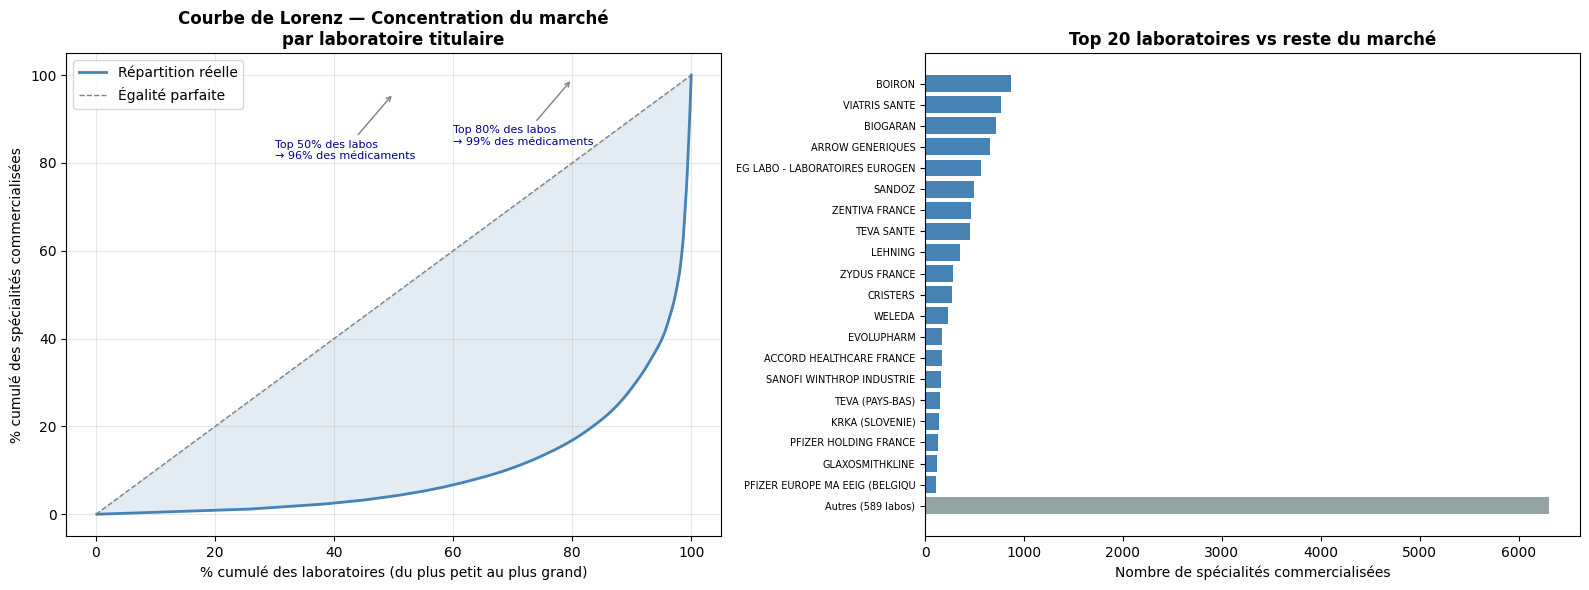

Nombre total de laboratoires titulaires : 609
Top 1 lab  → 6.4% des spécialités commercialisées
Top 10 labs → 41.4% des spécialités commercialisées


In [19]:
# Lorenz curve: sort labs by portfolio size, compute cumulative share
lab_sizes = (
    specialites[specialites["etat_commercialisation"] == "Commercialisée"]
    ["titulaire"].str.strip().value_counts().sort_values()
)
total_drugs = lab_sizes.sum()
cumulative_labs  = [i / len(lab_sizes) * 100 for i in range(1, len(lab_sizes) + 1)]
cumulative_drugs = (lab_sizes.cumsum() / total_drugs * 100).values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Lorenz curve ---
axes[0].plot(cumulative_labs, cumulative_drugs, color="steelblue", linewidth=2, label="Répartition réelle")
axes[0].plot([0, 100], [0, 100], color="gray", linestyle="--", linewidth=1, label="Égalité parfaite")
axes[0].fill_between(cumulative_labs, cumulative_drugs, cumulative_labs, alpha=0.15, color="steelblue")
axes[0].set_xlabel("% cumulé des laboratoires (du plus petit au plus grand)")
axes[0].set_ylabel("% cumulé des spécialités commercialisées")
axes[0].set_title("Courbe de Lorenz — Concentration du marché\npar laboratoire titulaire", fontsize=12, fontweight="bold")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Annotate key thresholds
for pct_labs in [20, 50]:
    idx = int(pct_labs / 100 * len(lab_sizes))
    pct_drugs = cumulative_drugs[idx]
    axes[0].annotate(
        f"Top {100-pct_labs}% des labos\n→ {100-pct_drugs:.0f}% des médicaments",
        xy=(100 - pct_labs, 100 - pct_drugs),
        xytext=(100 - pct_labs - 20, 100 - pct_drugs - 15),
        arrowprops={"arrowstyle": "->", "color": "gray"},
        fontsize=8, color="darkblue"
    )

# --- Pareto bar: top 20 labs vs rest ---
top20 = lab_sizes.sort_values(ascending=False).head(20)
rest_count = lab_sizes.sort_values(ascending=False).iloc[20:].sum()
rest_n_labs = len(lab_sizes) - 20

bar_labels = [l[:30] for l in top20.index] + [f"Autres ({rest_n_labs} labos)"]
bar_values = list(top20.values) + [rest_count]
bar_colors = ["steelblue"] * 20 + ["#95a5a6"]

axes[1].barh(range(len(bar_labels)), bar_values, color=bar_colors)
axes[1].set_yticks(range(len(bar_labels)))
axes[1].set_yticklabels(bar_labels, fontsize=7)
axes[1].set_xlabel("Nombre de spécialités commercialisées")
axes[1].set_title("Top 20 laboratoires vs reste du marché", fontsize=12, fontweight="bold")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

top10_share = lab_sizes.sort_values(ascending=False).head(10).sum() / total_drugs * 100
top1_share  = lab_sizes.sort_values(ascending=False).head(1).sum()  / total_drugs * 100
print(f"Nombre total de laboratoires titulaires : {len(lab_sizes):,}")
print(f"Top 1 lab  → {top1_share:.1f}% des spécialités commercialisées")
print(f"Top 10 labs → {top10_share:.1f}% des spécialités commercialisées")